In [14]:
# INSTALL OR BATCH LEARNING FAILS.
%pip install scikit-learn==1.5.2


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /home/marcos/.venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
# Reading data and plot it.
import pandas as pd
import matplotlib.pyplot as plt

# Stream learning
from river import compose, preprocessing, linear_model, tree, metrics, evaluate, feature_extraction, \
    utils, stats, compat, drift

# Batch learning 
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns

# Load dataset

In [16]:
# Read api request from a csv
df = pd.read_csv("datasets/data.csv")

# Create the target feature and eliminate redundant features
df["temp_diff_6h"] = df["main.temp"].diff(periods=6)
df["target"] = (df["temp_diff_6h"] > 0).astype(int)
df = df.drop(["Unnamed: 0","temp_diff_6h", "weather.main", "weather.description", "weather.icon"], axis = 1)
df.head(2)

,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,wind.gust,clouds.all,weather.id,rain.1h,target
0,1708617600,10.79,9.83,1010,73,9.14,11.61,7.72,290,14.92,75,803,NaN,0
1,1708621200,9.69,7.35,1010,81,8.58,11.40,4.63,290,NaN,75,803,NaN,0


# Analisis descriptivo

Numerical features

In [17]:
# Check numerical features and number of nulls
exclude_features = ["dt", "weather.id"]
summary = df.drop(columns=exclude_features).describe().transpose()
summary['null_count'] = df.isnull().sum()

# Drop these two columns because they have too many nulls
df = df.drop(["wind.gust", "rain.1h"], axis = 1)
summary

,count,mean,std,min,25%,50%,75%,max,null_count
main.temp,8105.0,15.223013,4.343804,0.40,12.26,15.26,18.36,30.82,0
main.feels_like,8105.0,14.867462,4.948661,-2.62,11.76,15.08,18.39,34.06,0
main.pressure,8105.0,1016.258606,8.609523,976.00,1012.00,1017.00,1021.00,1038.00,0
main.humidity,8105.0,83.708822,10.288154,0.00,78.00,86.00,91.00,100.00,0
main.temp_min,8105.0,14.090116,4.354793,0.40,11.36,14.32,17.16,29.75,0
main.temp_max,8105.0,16.279006,4.421052,2.47,13.27,16.07,19.40,33.15,0
wind.speed,8105.0,3.732584,2.353262,0.00,2.06,3.13,4.92,18.78,0
wind.deg,8105.0,183.830845,110.814811,0.00,117.00,180.00,280.00,360.00,0
wind.gust,1279.0,8.259398,5.200455,0.45,3.58,7.60,12.35,25.21,6826
clouds.all,8105.0,41.251203,35.334767,0.00,0.00,40.00,75.00,100.00,0


Categorical features

In [18]:
df['weather.id'] = df['weather.id'].astype('category')
summary = df['weather.id'].describe(include=['category']).transpose()
summary

count     8105
unique      16
top        800
freq      2190
Name: weather.id, dtype: int64

Class distribution

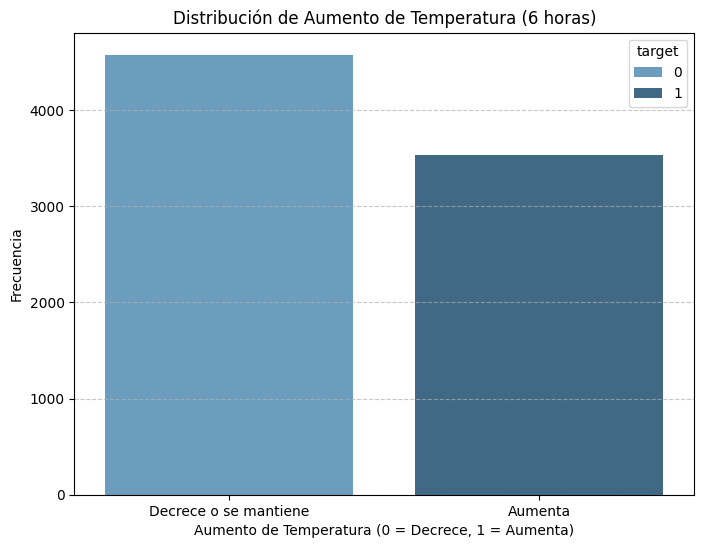

In [19]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=df, palette="Blues_d")

# Labeling the plot
plt.xlabel("Aumento de Temperatura (0 = Decrece, 1 = Aumenta)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Aumento de Temperatura (6 horas)")
plt.xticks(ticks=[0, 1], labels=['Decrece o se mantiene', 'Aumenta'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

Class distribution by time

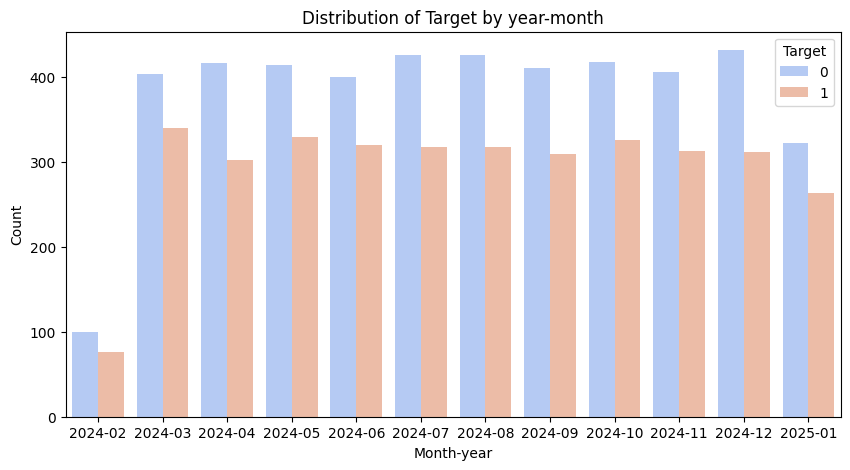

In [20]:
df["year_month"] = pd.to_datetime(df["dt"], unit="s").dt.to_period("M")

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="year_month", hue="target", palette="coolwarm")

# Labels and title
plt.xlabel("Month-year")
plt.ylabel("Count")
plt.title("Distribution of Target by year-month")
plt.legend(title="Target", labels=["0", "1"])
plt.show()

# Pipeline

In [46]:
import copy
from river import stream

def create_model(modelo):
    cols_rolling = ["main.temp", "main.feels_like", "main.pressure", "main.humidity", "wind.speed", "wind.deg"]
    to_discard = ['Unnamed: 0', 'wind.gust', 'weather.main', 'weather.description', 'weather.icon', 'rain.1h', 'temp_diff_6h'
                  "year_month"]

    def get_date_features(x):
        x["dt"] = pd.to_datetime(x["dt"], unit = "s")
        month =  x['dt'].month
        return {'month': month}

    model = get_date_features
    model |= compose.Discard(*to_discard)
    
    for col in cols_rolling:
        model += feature_extraction.Agg(on = col, by=None, how=utils.Rolling(stats.Mean(), 1))

    model |= preprocessing.StandardScaler()
    model |= modelo

    return model

def stream_learning(X, y, X_test, y_test, modelo, drift_detect):
    # Almacenamos los accuracies y los indices donde hay cambios.
    drifts = []
    acc_values = []

    # Inicializamos modelo, detector de drift y metricas
    drift_detector = copy.deepcopy(drift_detect)
    model = copy.deepcopy(modelo)
    acc2 = metrics.Accuracy()
    report2 = metrics.ClassificationReport()

    counter = 0
    for xi, yi in stream.iter_pandas(X, y):

        if drift_detector.drift_detected:
            print(f'Change detected at index {counter}')
            print(acc2.get())
            # Guardar el indice donde se detecta un cambio.
            drifts.append(counter)
            # Reiniciar el modelo cuando se detecta un cambio
            model = copy.deepcopy(modelo)
            # Reiniciar concept drift
            drift_detector = copy.deepcopy(drift_detect)

        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        if y_pred != None:
            #Actualizamos el drift detector
            drift_detector.update(yi)

        if counter % 100 == 0 and counter!=0:
            report2.update(yi, y_pred)
            acc2.update(yi, y_pred)
            acc_values.append(acc2.get())
        counter += 1

    for xi, yi in stream.iter_pandas(X_test, y_test):
        if drift_detector.drift_detected:
            print(f'Change detected at index {counter}')
            print(acc2.get())
            # Guardar el indice donde se detecta un cambio.
            drifts.append(counter)
            # Reiniciar el modelo cuando se detecta un cambio
            model = copy.deepcopy(modelo)
            # Reiniciar drift detector
            drift_detector = copy.deepcopy(drift_detect)

        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)
        
        if y_pred != None:
            report2.update(yi, y_pred)
            acc2.update(yi, y_pred)
            #Actualizamos el drift detector
            drift_detector.update(yi)

        if counter % 100 == 0 and counter!=0:
            acc_values.append(acc2.get())
        counter += 1

    return acc_values, drifts, report2

# Train-test partition

In [22]:
test_df = df.tail(1000)
train_df = df.iloc[:-1000]

X_train = train_df
y_train = X_train.pop('target')
X_test = test_df
y_test = X_test.pop('target')

# Stream learning results

Change detected at index 7666
0.6534810126582279
Change detected at index 7666
0.6534810126582279
Change detected at index 7246
0.5943396226415094
Results for LogisticRegression:
Accuracies: [0.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.3333333333333333, 0.42857142857142855, 0.5, 0.5555555555555556, 0.5, 0.45454545454545453, 0.5, 0.5384615384615384, 0.5714285714285714, 0.6, 0.5625, 0.5882352941176471, 0.6111111111111112, 0.631578947368421, 0.65, 0.6666666666666666, 0.6363636363636364, 0.6521739130434783, 0.6666666666666666, 0.68, 0.6923076923076923, 0.7037037037037037, 0.6785714285714286, 0.6896551724137931, 0.6666666666666666, 0.6451612903225806, 0.65625, 0.6363636363636364, 0.6176470588235294, 0.6285714285714286, 0.6388888888888888, 0.6486486486486487, 0.6578947368421053, 0.6666666666666666, 0.65, 0.6585365853658537, 0.6666666666666666, 0.6511627906976745, 0.6590909090909091, 0.6666666666666666, 0.6521739130434783, 0.6595744680851063, 0.6666666666666666, 0.6530612244897959, 0.66, 0.666

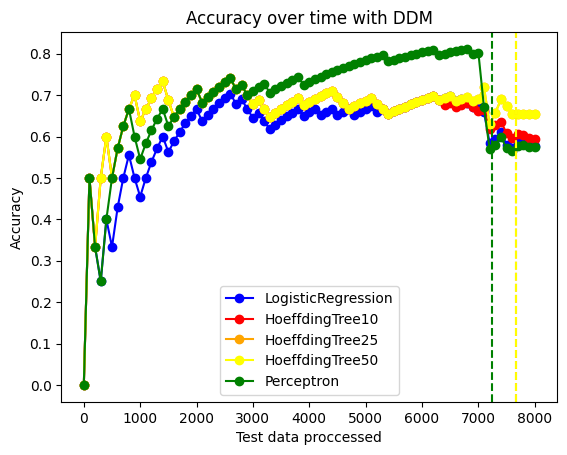

In [47]:
def get_models_results(X_train, y_train, X_test, y_test, models, drift_detector):
    accuracies = []
    drifts = []
    reports = []

    for model in models:
        model_instance = create_model(model)
        accuracies_model, drifts_model, report_model = stream_learning(X_train, y_train, X_test, y_test,
                                                                       modelo=model_instance, drift_detect=drift_detector)
        
        accuracies.append(accuracies_model)
        drifts.append(drifts_model)
        reports.append(report_model)

    # Optionally, you can zip the results and print them together
    for i, model in enumerate(models):
        print(f"Results for {model.__class__.__name__}:")
        print("Accuracies:", accuracies[i])
        print("Drifts:", drifts[i])
        print("Report:", reports[i])
        print("\n")

    return accuracies, drifts, reports

# Muestra el resultado de dos modelos, hay que adaptarla para que saque 3.
def plot_accuracy_dual(acc_list, drifts, colors, labels, title):
    """
    Plots the accuracy of the model with a detector, visualizing the points with 
    a concept drift.

    Parámetros:
    - acc_list: Lista con los valores de precisión para cada modelo incremental con detector.
    - drifts: Lista con los indices donde se produjeron cambios de la distribución para cada modelo.
    """

    for i, acc_values in enumerate(acc_list):
        color = colors[i]
        label = labels[i]
        indices = np.arange(len(acc_values))
        indices = indices*100
        plt.plot(indices, acc_values, label=label, color=color, marker='o')

    for i, drift in enumerate(drifts):
        color = colors[i]
        label = labels[i]
        for value in drift:
            plt.axvline(x=value, color=color, linestyle='--')

    plt.legend()
    plt.xlabel('Test data proccessed')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()

# Obtain results.
models = [linear_model.LogisticRegression(),
          tree.HoeffdingTreeClassifier(grace_period=10),
          tree.HoeffdingTreeClassifier(grace_period=25),
          tree.HoeffdingTreeClassifier(grace_period=50),
          linear_model.Perceptron()]

# Plot results
colors = ["blue", "red", "orange", "yellow", "green"]
labels = ["LogisticRegression", "HoeffdingTree10", "HoeffdingTree25", "HoeffdingTree50", "Perceptron"]
acc, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector= drift.binary.DDM(warm_start=100))
plot_accuracy_dual(acc, drifts, colors, labels, title = "Accuracy over time with DDM")

Change detected at index 264
0.5
Change detected at index 500
0.25
Change detected at index 837
0.25
Change detected at index 264
0.5
Change detected at index 500
0.25
Change detected at index 837
0.5
Results for LogisticRegression:
Accuracies: [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.2857142857142857, 0.25, 0.3333333333333333, 0.3, 0.2727272727272727, 0.3333333333333333, 0.38461538461538464, 0.42857142857142855, 0.4666666666666667, 0.4375, 0.47058823529411764, 0.5, 0.5263157894736842, 0.55, 0.5714285714285714, 0.5454545454545454, 0.5652173913043478, 0.5833333333333334, 0.6, 0.6153846153846154, 0.6296296296296297, 0.6071428571428571, 0.6206896551724138, 0.6, 0.5806451612903226, 0.59375, 0.5757575757575758, 0.5588235294117647, 0.5714285714285714, 0.5833333333333334, 0.5945945945945946, 0.6052631578947368, 0.6153846153846154, 0.6, 0.6097560975609756, 0.6190476190476191, 0.6046511627906976, 0.6136363636363636, 0.6222222222222222, 0.6086956521739131, 0.5957446808510

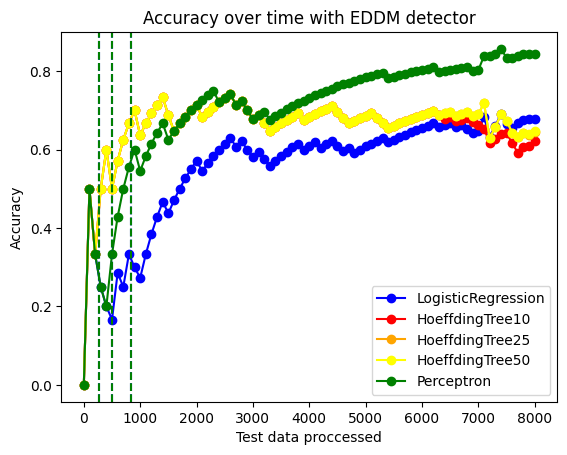

In [28]:
acc, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector= drift.binary.EDDM(warm_start=100))
plot_accuracy_dual(acc, drifts, colors, labels, title = "Accuracy over time with EDDM detector")

# Batch learning results

In [42]:
X_train.drop(["year_month"], axis = 1)

,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,clouds.all,weather.id
0,1708617600,10.79,9.83,1010,73,9.14,11.61,7.72,290,75,803
1,1708621200,9.69,7.35,1010,81,8.58,11.40,4.63,290,75,803
2,1708624800,9.04,6.77,1010,84,8.03,10.44,4.12,260,75,803
3,1708628400,8.74,6.66,1010,82,7.50,10.50,3.60,250,75,300
4,1708632000,8.17,5.24,1010,84,6.92,9.38,5.14,250,75,300
...,...,...,...,...,...,...,...,...,...,...,...
7100,1734181200,12.17,11.22,1033,68,10.87,13.78,1.03,0,0,800
7101,1734184800,12.63,11.78,1032,70,11.92,13.78,1.03,0,0,800
7102,1734188400,13.79,13.00,1032,68,12.72,14.72,0.89,9,20,801
7103,1734192000,13.14,12.34,1033,70,12.10,14.20,2.68,332,20,801


In [44]:
river_model = linear_model.LogisticRegression()
river_pipeline = create_model(river_model)

sk_pipeline = compat.convert_river_to_sklearn(river_pipeline)
print(sk_pipeline)
sk_pipeline.fit(X_train.drop(["year_month"], axis = 1),y_train)

Pipeline(steps=[('TransformerUnion',
                 River2SKLTransformer(river_estimator=TransformerUnion (
  Pipeline (
    FuncTransformer (
      func="get_date_features"
    ),
    Discard (
      Unnamed: 0
      rain.1h
      temp_diff_6hyear_month
      weather.description
      weather.icon
      weather.main
      wind.gust
    )
  ),
  Agg (
    on="main.temp"
    by=None
    how=Rolling (
      obj=Mean ()
      window_size=1
    )
  ),
  Agg (
    on="main.feels_like"
    by=None
    how=Rolling (
      ob...
                ('StandardScaler',
                 River2SKLTransformer(river_estimator=StandardScaler (
  with_std=True
))),
                ('LogisticRegression',
                 River2SKLClassifier(river_estimator=LogisticRegression (
  optimizer=SGD (
    lr=Constant (
      learning_rate=0.01
    )
  )
  loss=Log (
    weight_pos=1.
    weight_neg=1.
  )
  l2=0.
  l1=0.
  intercept_init=0.
  intercept_lr=Constant (
    learning_rate=0.01
  )
  clip_gradient=1e

KeyError: 'dt'

In [38]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, roc_auc_score

# Define a determistic cross-validation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculate the performance for each fold of the cross validation
scorer = make_scorer(roc_auc_score)
scores = cross_val_score(sk_pipeline, X_train.drop(["year_month"], axis = 1), y_train, scoring=scorer, cv=cv)

print(f'ROC AUC: {scores.mean():.4f} (± {scores.std():.4f})')

ROC AUC: 0.6604 (± 0.0080)


In [ ]:
y_pred = sk_pipeline.predict(X_test)

In [73]:
X_train.head()

,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,clouds.all,weather.id,year_month
0,1708617600,10.79,9.83,1010,73,9.14,11.61,7.72,290,75,803,2024-02
1,1708621200,9.69,7.35,1010,81,8.58,11.40,4.63,290,75,803,2024-02
2,1708624800,9.04,6.77,1010,84,8.03,10.44,4.12,260,75,803,2024-02
3,1708628400,8.74,6.66,1010,82,7.50,10.50,3.60,250,75,300,2024-02
4,1708632000,8.17,5.24,1010,84,6.92,9.38,5.14,250,75,300,2024-02


In [67]:
from river import compose
model = compose.Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('ml_model', linear_model.LogisticRegression())
)

# This funtion returns an object of type SKLRegressorWrapper 
# which is compatible with the signature of sklearn
model = compat.convert_river_to_sklearn(model)